# Import required packages

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Convolution1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import seaborn as sns
# Word2vec
import gensim

# Utility
import ssl
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [2]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/santhosh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# DATASET
DATASET_COLUMNS = ["message", "label"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [4]:
df = pd.read_csv('d1.csv')
print(df.iloc[:10])

   Unnamed: 0                                            message  label
0           0  The lack of this understanding is a small but ...      1
1           1  i just told my parents about my depression and...      1
2           2  depression is something i don't speak about ev...      1
3           3  Made myself a tortilla filled with pb&j. My de...      1
4           4  @WorldofOutlaws I am gonna need depression med...      1
5           5  my anxiety and my depression fighting over who...      1
6           6  wow she's suddenly cured my depression and gav...      1
7           7  I am officially done with @kanyewest. him, the...      1
8           8  Me: what's wrong?My girl: *looks up at me with...      1
9           9  @AusBorderForce @PeterDutton_MP @shanebazzi Ag...      1


**Preprocessing**

In [5]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [6]:
def preprocess(text, stem=True):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)


In [8]:
print(preprocess("buses", stem = True))

buse


In [9]:
print(df.head())
df.message = df.message.apply(lambda x: preprocess(x))

print("after preprocessing")
print(df.head())


   Unnamed: 0                                            message  label
0           0  The lack of this understanding is a small but ...      1
1           1  i just told my parents about my depression and...      1
2           2  depression is something i don't speak about ev...      1
3           3  Made myself a tortilla filled with pb&j. My de...      1
4           4  @WorldofOutlaws I am gonna need depression med...      1
after preprocessing
   Unnamed: 0                                            message  label
0           0  lack understand small signific part caus anxie...      1
1           1  told parent depress hard get gen x peopl under...      1
2           2  depress someth speak even go also doubl edg sw...      1
3           3  made tortilla fill pb j depress cure olivia 1 ...      1
4           4  gonna need depress med soon rainout spin equil...      1


In [10]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 6524
TEST size: 1631


In [11]:
documents = [_message.split() for _message in df_train.message]
print(documents[:10])

[['repost', 'britishmuseum', 'repostapp', 'see', 'magnific', '19th', 'centuri', 'sudaneselyr', 'new'], ['icymi', 'research', 'link', 'sens', 'purpos', 'lower', 'level', 'adolesc', 'depress', 'less'], ['look', 'forward', 'amelia', 'smith', 'speak', 'cda', 'innov', 'showcas', 'nationalgalleri', 'birkbecknew', 'cdavalu'], ['honey', 'told', 'listen', 'song', 'often', 'els', 'spiral', 'monsoon', 'depress', 'passion'], ['depress', 'pain', 'hole', 'noth', 'go', 'distinct', 'wrong', 'life', 'still', 'want', 'fuck', 'tall', 'build'], ['everi', 'singl', 'person', 'world', 'everi', 'cultur', 'everi', 'languag', 'everi', 'countri', 'know', 'eat', 'food', 'matter', 'food', 'bodi', 'enough', 'must', 'food', 'soul', 'depress', 'food', 'health', 'organ', 'pic', 'twitter', 'com', 'nlj5b3jki5'], ['woke', 'alreadi', 'think', 'take', 'depress', 'nap'], ['girlfriend', 'dog', 'alway', 'look', 'like', 'suffer', 'sever', 'depress', 'boy', 'relat', 'pic', 'twitter', 'com', 'u6zoe0rgq3'], ['excit', 'see'], ['th

In [12]:
w2v_model = gensim.models.Word2Vec(vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)

In [13]:
w2v_model.build_vocab(documents)

In [14]:
words = w2v_model.wv.key_to_index
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1188


In [16]:

w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
print(documents[0]);

['repost', 'britishmuseum', 'repostapp', 'see', 'magnific', '19th', 'centuri', 'sudaneselyr', 'new']


In [17]:
w2v_model.wv.most_similar("hate")

[('kind', 0.6193754076957703),
 ('weight', 0.5618546605110168),
 ('gain', 0.537340521812439),
 ('less', 0.5251399278640747),
 ('smoke', 0.5248550772666931),
 ('practic', 0.5211370587348938),
 ('job', 0.5102863311767578),
 ('rn', 0.5047264099121094),
 ('turn', 0.5018884539604187),
 ('carri', 0.49905428290367126)]

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.message)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 9560


In [19]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.message), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.message), maxlen=SEQUENCE_LENGTH)

In [20]:
x_train[0:10]

array([[   0,    0,    0, ..., 1302, 2542,   38],
       [   0,    0,    0, ...,  756,    1,  548],
       [   0,    0,    0, ...,   54, 3123, 3124],
       ...,
       [   0,    0,    0, ...,    4,    6, 3129],
       [   0,    0,    0, ...,    0,  183,   23],
       [   0,    0,    0, ...,  799,  207,  759]], dtype=int32)

In [21]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (6524, 1)
y_test (1631, 1)


In [22]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6524, 300)
y_train (6524, 1)

x_test (1631, 300)
y_test (1631, 1)


In [23]:
y_train[50:70]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1]])

In [24]:
print(tokenizer.word_index.items())

dict_items([('depress', 1), ('anxieti', 2), ('emoji', 3), ('twitter', 4), ('pic', 5), ('com', 6), ('like', 7), ('go', 8), ('day', 9), ('love', 10), ('get', 11), ('face', 12), ('one', 13), ('good', 14), ('know', 15), ('feel', 16), ('peopl', 17), ('thank', 18), ('britishmuseum', 19), ('time', 20), ('great', 21), ('help', 22), ('see', 23), ('work', 24), ('today', 25), ('think', 26), ('life', 27), ('make', 28), ('realli', 29), ('look', 30), ('thing', 31), ('mental', 32), ('much', 33), ('want', 34), ('back', 35), ('u', 36), ('well', 37), ('new', 38), ('take', 39), ('happi', 40), ('tri', 41), ('got', 42), ('amp', 43), ('year', 44), ('never', 45), ('health', 46), ('need', 47), ('come', 48), ('someon', 49), ('way', 50), ('talk', 51), ('use', 52), ('suicid', 53), ('nationalgalleri', 54), ('would', 55), ('us', 56), ('lol', 57), ('even', 58), ('right', 59), ('say', 60), ('friend', 61), ('suffer', 62), ('heart', 63), ('2', 64), ('caus', 65), ('hope', 66), ('cure', 67), ('cri', 68), ('stress', 69),

In [25]:
w2v_model.wv['depress']

array([ 7.87526276e-03, -3.85458499e-01,  1.84414044e-01,  2.74373531e-01,
       -2.69774884e-01,  3.24491709e-01,  3.09029762e-02, -3.92794251e-01,
       -8.20265058e-03, -2.00350523e-01,  1.99668124e-01,  1.85033843e-01,
       -4.56319481e-01,  2.13175610e-01, -1.65542662e-01, -1.21345669e-01,
       -4.52602059e-01, -1.56882137e-01,  4.18859363e-01,  1.24310870e-02,
        3.83397996e-01, -8.39689630e-04, -3.84247661e-01, -1.68948188e-01,
       -2.58572791e-02, -6.93642914e-01,  5.10567129e-01,  2.27456182e-01,
       -1.75679311e-01,  2.01925233e-01, -1.02075636e-01,  2.29704514e-01,
       -1.10979214e-01, -1.03579842e-01, -1.61952600e-01, -3.41527343e-01,
       -1.53274998e-01,  3.68724577e-02, -3.29231799e-01, -1.70102254e-01,
       -1.43959835e-01,  1.22976936e-02, -2.68152148e-01,  1.56316012e-01,
       -2.53796518e-01, -9.91434380e-02, -3.60850990e-01,  1.14081196e-01,
        1.53221274e-02, -7.44309068e-01, -6.90887868e-01,  2.10404024e-01,
        3.62755847e-04,  

In [26]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(9560, 300)


In [27]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

**LSTM Model**

In [28]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          2868000   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 3,087,777
Trainable params: 219,777
Non-trainable params: 2,868,000
_________________________________________________________________


In [29]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [30]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [31]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8


2023-05-19 10:20:49.921789: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6/6 [==============================] - 33s 5s/step - loss: 0.5222 - accuracy: 0.7559 - val_loss: 0.3678 - val_accuracy: 0.8652 - lr: 0.0010
Epoch 2/8
6/6 [==============================] - 30s 5s/step - loss: 0.2518 - accuracy: 0.9118 - val_loss: 0.2221 - val_accuracy: 0.9051 - lr: 0.0010
Epoch 3/8
6/6 [==============================] - 30s 5s/step - loss: 0.1513 - accuracy: 0.9492 - val_loss: 0.1247 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 4/8
6/6 [==============================] - 38s 7s/step - loss: 0.1072 - accuracy: 0.9685 - val_loss: 0.0774 - val_accuracy: 0.9755 - lr: 0.0010
Epoch 5/8
6/6 [==============================] - 31s 5s/step - loss: 0.0720 - accuracy: 0.9808 - val_loss: 0.0478 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 6/8
6/6 [==============================] - 27s 4s/step - loss: 0.0500 - accuracy: 0.9865 - val_loss: 0.0343 - val_accuracy: 0.9923 - lr: 0.0010
Epoch 7/8
6/6 [==============================] - 27s 5s/step - loss: 0.0410 - accuracy: 0.9886 - val_loss: 0.0

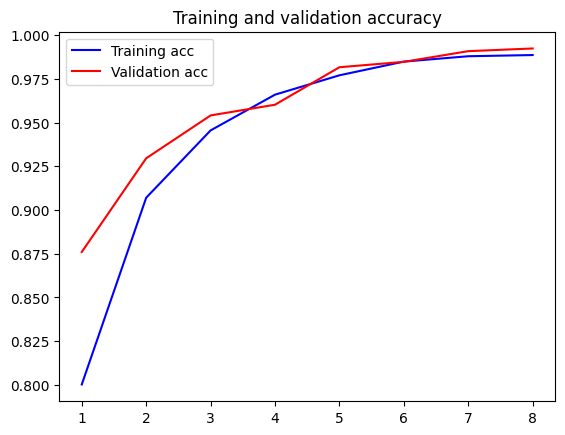

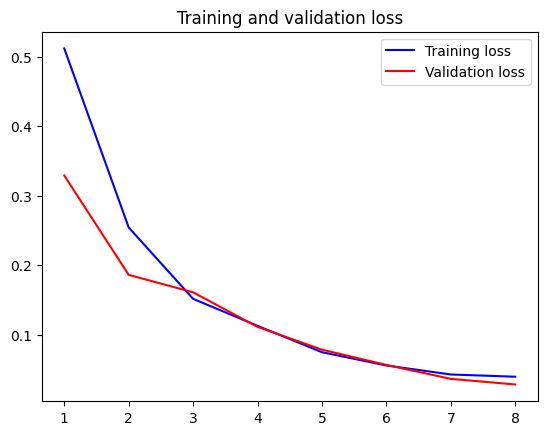

In [343]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [32]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print(score)
print("LSTM\nACCURACY:",score[1])
print("LOSS:",score[0])

2/2 [==============================] - 2s 920ms/step - loss: 0.0476 - accuracy: 0.9877
[0.047641951590776443, 0.9877375960350037]
LSTM
ACCURACY: 0.9877375960350037
LOSS: 0.047641951590776443


In [33]:
labels_pred = model.predict(x_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(y_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

51/51 [==============================] - 13s 253ms/step
Accuracy: 98.77%


In [34]:
report = classification_report(y_test, labels_pred, output_dict=True)
print(report)

{'0': {'precision': 0.9731903485254692, 'recall': 1.0, 'f1-score': 0.9864130434782609, 'support': 726}, '1': {'precision': 1.0, 'recall': 0.9779005524861878, 'f1-score': 0.988826815642458, 'support': 905}, 'accuracy': 0.987737584304108, 'macro avg': {'precision': 0.9865951742627346, 'recall': 0.988950276243094, 'f1-score': 0.9876199295603594, 'support': 1631}, 'weighted avg': {'precision': 0.9880663353951507, 'recall': 0.987737584304108, 'f1-score': 0.9877523836429442, 'support': 1631}}


In [35]:
data = [['precision', report['1']['precision']], ['recall', report['1']['recall']], ['accuracy', report['accuracy']], ['f1-score', report['1']['f1-score']]]
df_lstm = pd.DataFrame(data, columns=['cat', 'val'])
df_lstm['source'] = 'lstm'
df_lstm.head()

,cat,val,source
0,precision,1.000000,lstm
1,recall,0.977901,lstm
2,accuracy,0.987738,lstm
3,f1-score,0.988827,lstm


In [51]:
def decode_sentiment(score):
    return NEGATIVE if score < 0.4 else POSITIVE

In [52]:
def predict(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
    text = " ".join(tokens)
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict(x_test)[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [53]:
predict("i hate my life, suicide is the only option")

1/1 [==============================] - 0s 54ms/step


{'label': 'POSITIVE',
 'score': 0.4678723216056824,
 'elapsed_time': 0.08474373817443848}

In [54]:
predict("I enjoyed the vacations, it was so enjoyable")

1/1 [==============================] - 0s 50ms/step


{'label': 'NEGATIVE',
 'score': 0.0026495163328945637,
 'elapsed_time': 0.07707405090332031}

In [55]:
predict("i think i diagnose mental ilness and disorders")

1/1 [==============================] - 0s 51ms/step


{'label': 'POSITIVE',
 'score': 0.8396480083465576,
 'elapsed_time': 0.07980918884277344}

In [56]:
predict("i failed my exams, i am mentally so stressed right now")

1/1 [==============================] - 0s 51ms/step


{'label': 'POSITIVE',
 'score': 0.8483155369758606,
 'elapsed_time': 0.07765007019042969}

In [57]:
predict("last week was so nice, had fun with friends")

1/1 [==============================] - 0s 73ms/step


{'label': 'NEGATIVE',
 'score': 0.0021864280570298433,
 'elapsed_time': 0.12343597412109375}

In [58]:
predict("last week birthday celebration party was so enjoyable, i was so happy, memorable day ever")

1/1 [==============================] - 0s 68ms/step


{'label': 'NEGATIVE',
 'score': 0.0013472730061039329,
 'elapsed_time': 0.10190200805664062}

**CNN**

In [59]:
model = Sequential()
model.add(embedding_layer)
model.add(Convolution1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [60]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          2868000   
                                                                 
 conv1d (Conv1D)             (None, 298, 32)           28832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 149, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 147, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 73, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 71, 64)           

In [61]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,epochs=12,
                    validation_split=0.1,verbose=1,callbacks=callbacks)

Epoch 1/12
6/6 [==============================] - 5s 678ms/step - loss: 0.6204 - accuracy: 0.5898 - val_loss: 0.5751 - val_accuracy: 0.5360 - lr: 0.0010
Epoch 2/12
6/6 [==============================] - 4s 642ms/step - loss: 0.5451 - accuracy: 0.5868 - val_loss: 0.5254 - val_accuracy: 0.6891 - lr: 0.0010
Epoch 3/12
6/6 [==============================] - 4s 646ms/step - loss: 0.5122 - accuracy: 0.7130 - val_loss: 0.5031 - val_accuracy: 0.7749 - lr: 0.0010
Epoch 4/12
6/6 [==============================] - 4s 687ms/step - loss: 0.4896 - accuracy: 0.7483 - val_loss: 0.4885 - val_accuracy: 0.7841 - lr: 0.0010
Epoch 5/12
6/6 [==============================] - 4s 674ms/step - loss: 0.4761 - accuracy: 0.7602 - val_loss: 0.4835 - val_accuracy: 0.7841 - lr: 0.0010
Epoch 6/12
6/6 [==============================] - 4s 705ms/step - loss: 0.4690 - accuracy: 0.7658 - val_loss: 0.4763 - val_accuracy: 0.7841 - lr: 0.0010
Epoch 7/12
6/6 [==============================] - 4s 659ms/step - loss: 0.4622 - a

In [62]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("CNN\nACCURACY:",score[1])
print("LOSS:",score[0])

2/2 [==============================] - 0s 225ms/step - loss: 0.4620 - accuracy: 0.7646

CNN
ACCURACY: 0.7645615935325623
LOSS: 0.4619642198085785


In [63]:
labels_pred = model.predict(x_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(y_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

51/51 [==============================] - 1s 12ms/step
Accuracy: 76.46%


In [64]:
report = classification_report(y_test, labels_pred, output_dict=True)
report

{'0': {'precision': 0.6734279918864098,
  'recall': 0.9146005509641874,
  'f1-score': 0.7757009345794392,
  'support': 726},
 '1': {'precision': 0.9038759689922481,
  'recall': 0.6441988950276243,
  'f1-score': 0.7522580645161291,
  'support': 905},
 'accuracy': 0.7645616186388718,
 'macro avg': {'precision': 0.7886519804393289,
  'recall': 0.7793997229959058,
  'f1-score': 0.7639794995477842,
  'support': 1631},
 'weighted avg': {'precision': 0.8012976542290117,
  'recall': 0.7645616186388718,
  'f1-score': 0.7626930882230348,
  'support': 1631}}

In [65]:
data = [['precision', report['weighted avg']['precision']], ['recall', report['weighted avg']['recall']], ['accuracy', report['accuracy']], ['f1-score', report['weighted avg']['f1-score']]]
df_cnn = pd.DataFrame(data, columns=['cat', 'val'])
df_cnn['source'] = 'cnn'
df_cnn.head()

,cat,val,source
0,precision,0.801298,cnn
1,recall,0.764562,cnn
2,accuracy,0.764562,cnn
3,f1-score,0.762693,cnn


**LSTM+CNN**

In [66]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, return_sequences=True))

model.add(Convolution1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Convolution1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [67]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          2868000   
                                                                 
 lstm_1 (LSTM)               (None, 300, 128)          219648    
                                                                 
 conv1d_3 (Conv1D)           (None, 298, 32)           12320     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 149, 32)          0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 149, 32)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 147, 64)           6208      
                                                      

In [68]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,epochs=EPOCHS,
                    validation_split=0.1,verbose=1,callbacks=callbacks)

Epoch 1/8
6/6 [==============================] - 23s 4s/step - loss: 0.6809 - acc: 0.5418 - val_loss: 0.6425 - val_acc: 0.5406 - lr: 0.0010
Epoch 2/8
6/6 [==============================] - 20s 3s/step - loss: 0.5607 - acc: 0.6702 - val_loss: 0.4628 - val_acc: 0.8178 - lr: 0.0010
Epoch 3/8
6/6 [==============================] - 20s 3s/step - loss: 0.4273 - acc: 0.7975 - val_loss: 0.3362 - val_acc: 0.8622 - lr: 0.0010
Epoch 4/8
6/6 [==============================] - 21s 4s/step - loss: 0.3406 - acc: 0.8520 - val_loss: 0.2934 - val_acc: 0.8928 - lr: 0.0010
Epoch 5/8
6/6 [==============================] - 20s 3s/step - loss: 0.2890 - acc: 0.8760 - val_loss: 0.2422 - val_acc: 0.9158 - lr: 0.0010
Epoch 6/8
6/6 [==============================] - 20s 3s/step - loss: 0.2528 - acc: 0.8901 - val_loss: 0.2119 - val_acc: 0.9234 - lr: 0.0010
Epoch 7/8
6/6 [==============================] - 19s 3s/step - loss: 0.2331 - acc: 0.8968 - val_loss: 0.2035 - val_acc: 0.9234 - lr: 0.0010
Epoch 8/8
6/6 [=====

In [69]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("Hybrid(CNN+LSTM)\nACCURACY:",score[1])
print("LOSS:",score[0])

2/2 [==============================] - 3s 998ms/step - loss: 0.2453 - acc: 0.8915

Hybrid(CNN+LSTM)
ACCURACY: 0.891477644443512
LOSS: 0.24527543783187866


In [70]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("CNN\nACCURACY:",score[1])
print("LOSS:",score[0])

2/2 [==============================] - 3s 1s/step - loss: 0.2453 - acc: 0.8915

CNN
ACCURACY: 0.891477644443512
LOSS: 0.24527543783187866


In [71]:
report = classification_report(y_test, labels_pred, output_dict=True)

In [76]:
data = [['precision', report['weighted avg']['precision']], ['recall', report['weighted avg']['recall']], ['weighted avg', report['accuracy']], ['f1-score', report['weighted avg']['f1-score']]]
df_hybrid = pd.DataFrame(data, columns=['cat', 'val'])
df_hybrid['source'] = 'hybrid'
df_hybrid.head()

,cat,val,source
0,precision,0.801298,hybrid
1,recall,0.764562,hybrid
2,weighted avg,0.764562,hybrid
3,f1-score,0.762693,hybrid


In [79]:
df_w2v = pd.concat([df_lstm, df_cnn, df_hybrid])
df_w2v

,cat,val,source
0,precision,1.000000,lstm
1,recall,0.977901,lstm
2,accuracy,0.987738,lstm
3,f1-score,0.988827,lstm
0,precision,0.801298,cnn
1,recall,0.764562,cnn
2,accuracy,0.764562,cnn
3,f1-score,0.762693,cnn
0,precision,0.801298,hybrid
1,recall,0.764562,hybrid


Text(0.5, 1.0, 'plot')

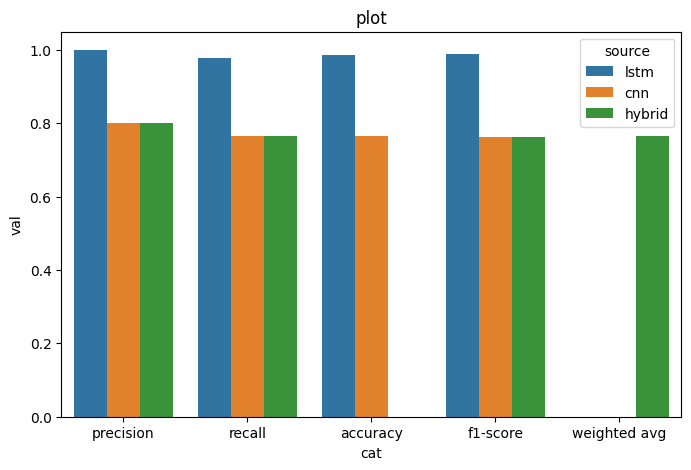

In [80]:
plt.figure(figsize=(8,5))
sns.barplot(x ='cat', y = 'val', data=df_w2v, hue='source')
plt.title("plot")